# Fisher Discriminant - Iris data set

### Authors: 
- Christian Michelsen (Niels Bohr Institute)
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 29-12-2019 (latest update)

***

Python macro for analysing the famous Anderson-Fisher Iris data set from Gaspe Peninsula. Edgar Anderson took 50 samples of three species (Setosa, Versicolor, and Virginica) of Iris at the Gaspe Peninsula, and measured four distinguishing features on each flower:

-    Sepal Length
-    Sepal Width
-    Petal Length
-    Petal Width

Using these measurements, Ronald Fisher was able to make a classification scheme, for which he invented the Fisher Linear Discriminant.


### References:
- Glen Cowan, Statistical Data Analysis, pages 51-57
- http://en.wikipedia.org/wiki/Iris_flower_data_set
- http://en.wikipedia.org/wiki/Linear_discriminant_analysis

***

First, we import the modules we want to use:

In [1]:
# First, import the modules you want to use:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from numpy.linalg import inv

In [2]:
r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)
save_plots = False          # For now, don't save plots (once you trust your code, switch on)

## Functions


In [3]:
def get_covariance_offdiag(X, Y):
    return np.cov(X, Y, ddof=1)[0, 1]


def calc_separation(x, y):
    
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    std_x = np.std(x, ddof=1)
    std_y = np.std(y, ddof=1)
    
    d = np.abs((mean_x - mean_y)) / np.sqrt(std_x**2 + std_y**2)
    
    return d

## Define parameters:

Define path to datafile

In [4]:
filename = "DataSet_AndersonFisherIris.txt"

Set the variable and species names along with the number of variavles and number of species:

In [5]:
var_name  = [ "Sepal Length", "Sepal Width", "Petal Length", "Petal Width" ] #Variable name
spec_name = [ "Setosa"      , "Versicolor" , "Virginica"                   ] #Species name

nvar  = len(var_name)  # Sepal Length, Sepal Width, Petal Length, Petal Width
nspec = len(spec_name)  # Setosa, Versicolor, Virginica

Set the range for the histograms to plot and the number of bins:

In [6]:
xmin = [3.5, 1.7, 0.0, 0.0] #Range for different variables
xmax = [8.5, 4.7, 7.5, 3.0]
nbin = [ 25,  30,  25,  30] #Number of bins for different variables

Set the colors and markers to use for each species:

In [7]:
colors = ['Red', 'Green', 'Blue']
markers = ['o', '^', 's']

## Loop over and read data from input

Now we open the file and save the data in the variable called `data`: 

In [8]:
data = [] # Container for all variables
with open(filename, 'r') as file:
    counter = 0
    for line in file:
        data.append(line.strip().split())               # Read line -> Convert to list
        for ivar in range(nvar): 
            data[-1][ivar] = float(data[-1][ivar])      # First nvar values are floats            
        data[-1][-1] = int(data[-1][4]) - 1             # Last one is an integer width species type: 1,2,3
                                                        # Start counting at 0, to match your lists : 0,1,2
        # Print some numbers as a sanity check
        if counter < 5 : 
            print(f"Read data: {data[-1][0]:5.2f} {data[-1][1]:5.2f} {data[-1][2]:5.2f} {data[-1][3]:5.2f}   {data[-1][4]:d} ")
        counter += 1

Read data:  5.10  3.50  1.40  0.20   0 
Read data:  4.90  3.00  1.40  0.20   0 
Read data:  4.70  3.20  1.30  0.20   0 
Read data:  4.60  3.10  1.50  0.20   0 
Read data:  5.00  3.60  1.40  0.20   0 


Below we show the numpy version of the above cell:

In [9]:
# Numpy version:
data = np.loadtxt(filename)
data[:, -1] -= 1            # Subtract one from all the last integers in the data:
                            # Last one is an integer width species type: 1,2,3
                            # Start counting at 0, to match your lists : 0,1,2

To introduce the notation that is very common in Machine Learning, we split the data up into the independent variable (input variables / features / columns) `X` and the dependent variable (output variable) `y`:

In [10]:
# X is the independent variable / input variables / features / columns
X = data[:, :-1]
# y is the dependent variable / output variable 
y = data[:, -1].astype(int)

Here the capital `X` refers to the fact that `X` is a matrix (2D-array) and `y` is a vector (1D-array).

## Display data:

Now we plot the data as histograms for each variable with each species colored according to: <span style="color:red">Setosa</span>, <span style="color:green">Versicolor</span>, and <span style="color:blue">Virginica</span>:

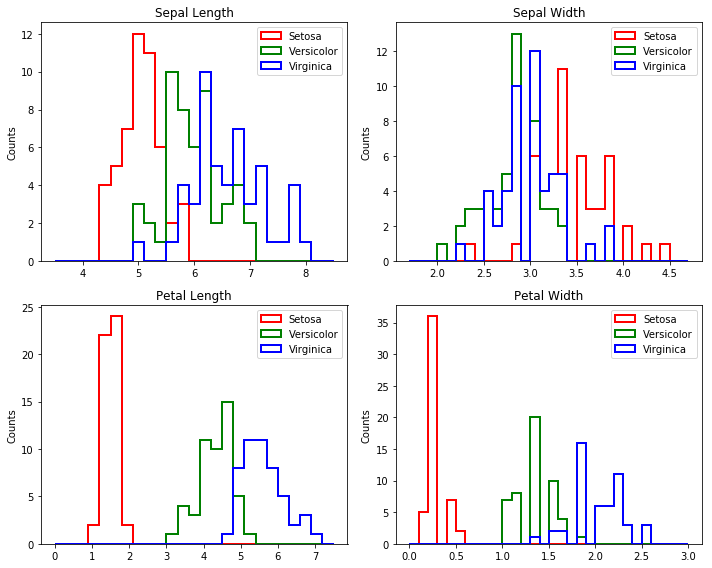

In [11]:
fig_1D, ax_1D = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
ax_1D = ax_1D.flatten()

mu = np.zeros((nspec, nvar))
std = np.zeros((nspec, nvar))

for ivar in range(nvar): # for each variable plot each species' corresponding histogram of that variable
    for ispec in range(nspec):
        
        data_spec = X[y == ispec]  # extract the relevant species
        data_spec_var = data_spec[:, ivar]      # extract the relevant variable
        
        ax_1D[ivar].hist(data_spec_var, nbin[ivar], range=(xmin[ivar], xmax[ivar]), histtype='step', color=colors[ispec], label=spec_name[ispec], lw=2)
        
        mu[ispec, ivar] = data_spec_var.mean()
        std[ispec, ivar] = data_spec_var.std(ddof=1)
         
    ax_1D[ivar].set(title=var_name[ivar], ylabel='Counts')
    ax_1D[ivar].legend()
    
fig_1D.tight_layout()

if save_plots:
    fig_1D.savefig('FisherInputHists.pdf', dpi=600)

Below we plot the same data as 2D scatter plots:

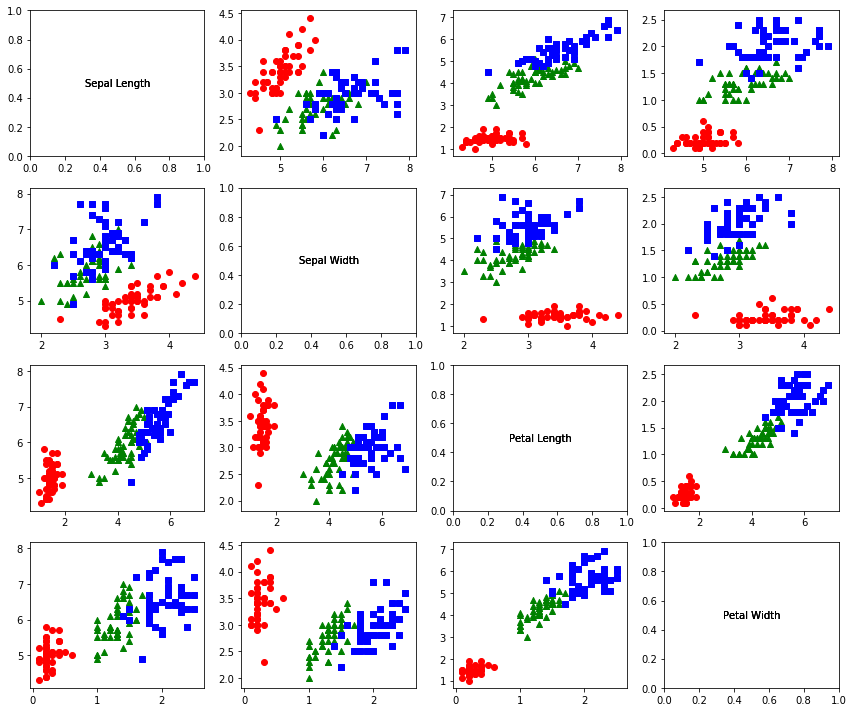

In [12]:
# Draw 2D histograms:
fig_corr, ax_corr = plt.subplots(nrows=4, ncols=4, figsize=(12, 10))
covariances = np.zeros((nvar, nvar, nspec))
for ivar in range(nvar):
    for jvar in range(nvar):
        
        ax = ax_corr[ivar, jvar]
        
        for ispec in range(nspec):
        
            data_ispec = data[data[:, -1] == ispec]  # extract the relevant species
            data_ispec_ivar = data_ispec[:, ivar]
            data_ispec_jvar = data_ispec[:, jvar]
                            
            covariances[ivar, jvar, ispec] = get_covariance_offdiag(data_ispec_ivar, data_ispec_jvar)

            if ivar == jvar: # i.e. diagonal
                ax.text(0.5, 0.5, var_name[ivar], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            else:
                ax.scatter(data_ispec_ivar, data_ispec_jvar, marker = markers[ispec], color = colors[ispec])
                
                
fig_corr.tight_layout()

if save_plots:
    fig_corr.savefig('FisherInputHists_corr.pdf', dpi=600)

## Make Fisher discriminant between species Versicolor (1) and Virginica (2): 
(i.e. not considering Setosa(0) for now).


Put the (co-)variances into a matrix, and invert it to get the Fisher coefficients: __NOTE__: Fill this in yourself

In [13]:
covmat_Vers = np.ones((4,4))        # Covariance matrix for Versicolor, change this yourself!
covmat_Virg = np.eye(4,4)         # Covariance matrix for Verginica, change this yourself!

In [14]:
# The calculations requires the inverted COMBINED covariance matrices:
print("Combined covariance matrix:")
covmat_comb = covmat_Vers + covmat_Virg
print(covmat_comb)
print("")

print("Inverted combined covariance matrix:")
covmat_comb_inv = inv(covmat_comb)
print(covmat_comb_inv)
print("")

Combined covariance matrix:
[[2. 1. 1. 1.]
 [1. 2. 1. 1.]
 [1. 1. 2. 1.]
 [1. 1. 1. 2.]]

Inverted combined covariance matrix:
[[ 0.8 -0.2 -0.2 -0.2]
 [-0.2  0.8 -0.2 -0.2]
 [-0.2 -0.2  0.8 -0.2]
 [-0.2 -0.2 -0.2  0.8]]



## Calculate Fisher coefficients:

Calculate the four Fisher coefficients: Do this yourself...

In [15]:
wf = np.array([0, 1, 2, 3])
print(wf)

[0 1 2 3]


Loop over the data (species Versicolor (1) and Virginica (2)), calculate their Fisher discriminant value, and see how well the separation works:

In [16]:





# fill in yourself






In [17]:
print(f"The separation between the samples is: {1234:5.2f} <-- fill this in yourself") 

The separation between the samples is: 1234.00 <-- fill this in yourself


# Questions

As always, make sure that you know what the code is doing so far, and what the aim of the exercise is (i.e. which problem to solve, and how). Then start to expand on it.

1. Look at the distributions of the four discriminating variables for the two species Versicolor (1) and Virginica (2), and see how well you can separate them by eye. It seems reasonably possible, but certainly not perfect...

2. Calculate the mean, widths (RMS) and covariance of each discriminating variable (pair of variables for covariance) for each species, and put these into the matrices defined.

3. From the inverted summed matrix, calculate the four Fisher coefficients, and given these, calculate the Fisher discriminant for the two species in question.

4. What separation did you get, and is it notably better than what you obtain by eye? Possibly make two ROC curves to quantify this.